# Maximum Likelihood Estimates (MLEs)

By Delaney Granizo-Mackenzie and Andrei Kirilenko developed as part of the Masters of Finance curriculum at MIT Sloan.

Part of the Quantopian Lecture Series:

* [www.quantopian.com/lectures](https://www.quantopian.com/lectures)
* [github.com/quantopian/research_public](https://github.com/quantopian/research_public)

Notebook released under the Creative Commons Attribution 4.0 License.

---

In this tutorial notebook we'll do the following things:

   1. Compute the MLE for a normal distribution.
   2. Compute the MLE for an exponential distribution.
   3. Fit a normal distribution to asset returns using MLE.

First we need to import some libraries.

In [19]:
import math
import matplotlib.pyplot as plt
import numpy as np
import scipy
import scipy.stats
%matplotlib inline
from matplotlib import style
style.use('seaborn-notebook')

## Normal Distribution

We'll start by sampling some data from a normal distribution.

In [2]:
TRUE_MEAN = 40
TRUE_STD = 10
X = np.random.normal(TRUE_MEAN, TRUE_STD, 1000)

Now we'll define functions that given our data, will compute the MLE for the $\mu$ and $\sigma$ parameters of the normal distribution.

Recall that

$$\hat\mu = \frac{1}{T}\sum_{t=1}^{T} x_t$$

$$\hat\sigma = \sqrt{\frac{1}{T}\sum_{t=1}^{T}{(x_t - \hat\mu)^2}}$$

In [5]:
def normal_mu_MLE(X):
    # Get the number of observations
    T = len(X)
    # Sum the observations
    s = sum(X)
    return (1.0 / T) * s

def normal_sigma_MLE(X):
    T = len(X)
    # Get the mu MLE
    mu = normal_mu_MLE(X)
    # Sum the square of the differences
    s = sum(np.power((X - mu), 2))
    # Compute sigma^2
    sigma_squared = (1.0 / T) * s
    return math.sqrt(sigma_squared)

Now let's try our function out on our sample data and see how they compare to the built-in `np.mean` and `np.std`

In [6]:
print('Mean Estimation: {0}, Numpy: {1}'.format(normal_mu_MLE(X), np.mean(X)))
print('Standard Deviation Estimation: {0}, Numpy: {1}'.format(normal_sigma_MLE(X), np.std(X)))

Mean Estimation: 39.678772213037476, Numpy: 39.678772213037476
Standard Deviation Estimation: 10.132751340940336, Numpy: 10.132751340940334


Now let's estimate both parameters at once with scipy's built in fit() function.

In [10]:
mu, std = scipy.stats.norm.fit(X)
print('mu estimate: ', mu)
print('std estimate: ', std)

mu estimate:  39.678772213
std estimate:  10.1327513409


Now let's plot the distribution PDF along with the data to see how well it fits. We can do that ny accessing the pdf provided in `scipy.stats.norm.pdf`.

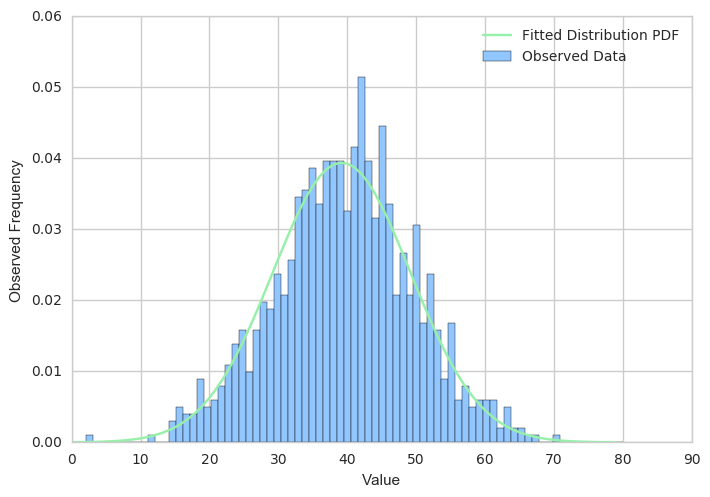

In [20]:
pdf = scipy.stats.norm.pdf
# We would like to plot our data along an x-axis ranging from 0-80 with 80 intervals
# (increments of 1)
x = np.linspace(0, 80, 80)
plt.hist(X, bins=x, normed='true')
plt.plot(pdf(x, loc=mu, scale=std))
plt.xlabel('Value')
plt.ylabel('Observed Frequency')
plt.legend(['Fitted Distribution PDF','Observed Data']);

## Exponential Distribution
Let's do the same thing, but for the exponential distribution. We'll start by sampling some data.

In [21]:
TRUE_LAMBDA = 5
X = np.random.exponential(TRUE_LAMBDA, 1000)

`numpy` defines the exponential distribution as
$$\frac{1}{\lambda}e^{-\frac{x}{\lambda}}$$

So we need to invert the MLE from the lecture notes. There it is

$$\hat\lambda = \frac{T}{\sum_{t=1}^{T} x_t}$$

Here it's just the reciprocal, so

$$\hat\lambda = \frac{\sum_{t=1}^{T} x_t}{T}$$

NOTE:

I Think the way that Quantopian has written it here is a bit unclear. I believe this is due to the way numpy defines te exponential distribution. Typically it is defined as

$$\lambda e^{-\lambda x}$$

where

$$\lambda = \frac{1}{\mu}$$

However for consistency, we will use the numpy definition in the following exercises.

In [23]:
def exp_lambda_MLE(X):
    T = len(X)
    s = sum(X)
    return s/T

In [24]:
print('lambda estimate: ', exp_lambda_MLE(X))

lambda estimate:  4.84460361943


In [28]:
# The scipy version of the exponential distribution has a location parameter
# that can skew the distribution. We ignore this by fixin the location
# parameter to 0 with floc=0
_, l = scipy.stats.expon.fit(X, floc=0)

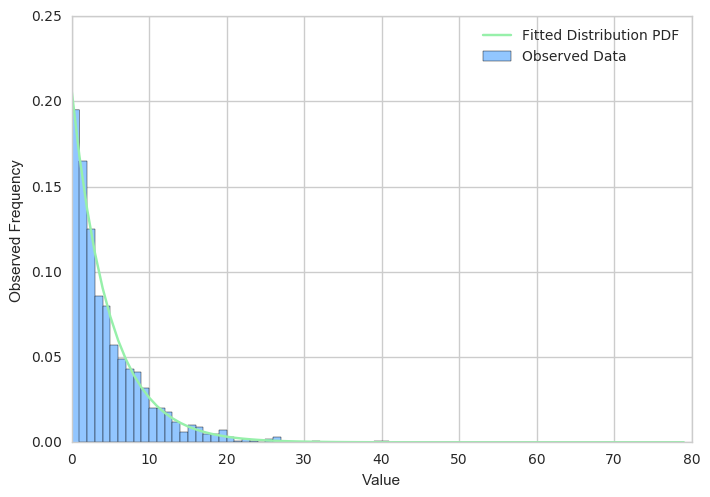

In [33]:
pdf = scipy.stats.expon.pdf
x = range(0,80)
plt.hist(X, bins = x, normed=True)
plt.plot(pdf(x, scale=l))
plt.xlabel('Value')
plt.ylabel('Observed Frequency')
plt.legend(['Fitted Distribution PDF','Observed Data',]);

## MLE for Asset Returns

Now we'll fetch some real returns and try to fit a normal distribution to them using MLE.

In [34]:
import pandas as pd
import pandas_datareader.data as web

In [44]:
prices = web.DataReader('TSLA', 'yahoo', start='2014-01-01', end='2015-01-01')
# This will give us the number of dollars returned each day

# # Quantopian's Way:
# # absolute_returns = np.diff(prices['Adj Close'])

# # I will instead use pandas built in function diff, my way:
# absolute_returns = prices['Adj Close'].diff()

# # % change calc
# returns = absolute_returns/prices['Adj Close']

# shortcut to avoid the computations above thanks to pandas:
returns = prices['Adj Close'].pct_change()[1:]
log_returns = np.log(1 + returns)

Let's use scipy's fit funtion to get the $\mu$ and $\sigma$ MLEs.

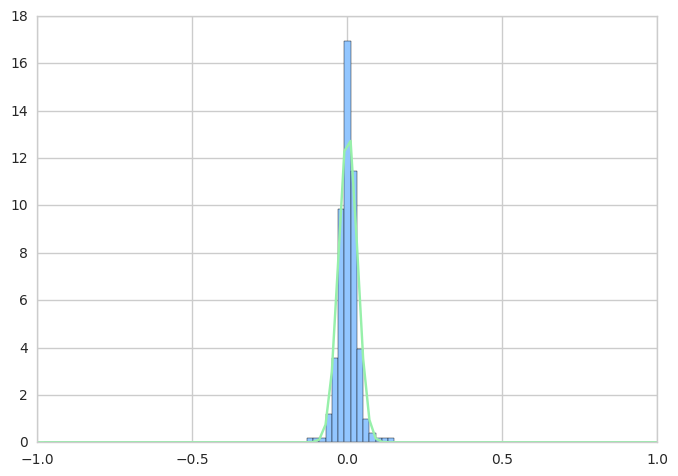

In [46]:
mu, std = scipy.stats.norm.fit(log_returns)
pdf = scipy.stats.norm.pdf
x = np.linspace(-1,1, num=100)
h = plt.hist(log_returns, bins=x, normed=True)
l = plt.plot(x, pdf(x, loc=mu, scale=std))

Of course, this fit is meaningless unless we've tested that they obey a normal distribution first. We can test this using the Jarque-Bera normality test. The Jarque-Bera test will reject the hypothesis of a normal distribution if the p-value is under a c

In [47]:
from statsmodels.stats.stattools import jarque_bera
jarque_bera(log_returns)

(182.15440201171478,
 2.7904495556333452e-40,
 0.4838864412142353,
 7.059626783985425)

2.79e-40 is the $p$-value, thus we reject the null hypothesis that the returns are normal.

In [50]:
jarque_bera(np.random.normal(mu,std,100))

(0.4331635318880809,
 0.80526668883970742,
 -0.160314220994853,
 2.965990444866286)

In [51]:
jarque_bera(np.random.normal(0,1,100))

(0.18724629589543332,
 0.91062586881402308,
 -0.10556059363927507,
 3.019156077286317)